In [1]:
import os
import pywt
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from src.models.simple import SimpleCNN

import yaml
import pickle
import importlib
from types import SimpleNamespace
from quantus.metrics import Complexity

from physioex.physioex.data import PhysioExDataModule
from physioex.physioex.train.models.load import load_model

from src.utils import split_string
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions
from src.attribution.wavelet.wavelet import WaveletFilterbank
from src.utils.sampling import downsample_wavedec, upsampling_wavedec


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
# set seed
set_seed(42)

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

# load the model
model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=5)

# load the model weights
model.load_state_dict(torch.load("./model/checkpoint/simpleCNN_4.pth", map_location=torch.device('mps')))
model.to(device)

Using device: mps


SimpleCNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 2, kernel_size=(5,), stride=(1,))
    (4): AdaptiveAvgPool1d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)

In [5]:
set_seed(42)

# Load and shape synthetic test data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test_4"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Shuffle indices once
indices = torch.randperm(len(x))

# Apply the shuffle
x_shuffled = x[indices]
y_shuffled = y[indices]

# create the dataset
dataset = TensorDataset(x_shuffled, y_shuffled)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128)


(10000, 1, 1000)
(10000,)


In [4]:
target_package = "physioex.train.networks.utils.target_transform"
target_class = "get_mid_label"
target = getattr(importlib.import_module(target_package), target_class)

set_seed(42)

datamodule = PhysioExDataModule(
    datasets=["sleepedf"],     # list of datasets to be used
    batch_size=64,            # batch size for the DataLoader
    preprocessing="raw",       # preprocessing method
    selected_channels=["EEG"], # channels to be selected
    sequence_length=7,         # length of the sequence
    target_transform= target,  # since seq to epoch, target seq
    num_workers = 8,          # number of parallel workers
    data_folder = "data"    # path to the data folder
)

In [5]:
# get the test DataLoaders
test_loader = datamodule.test_dataloader()

print(len(test_loader)) # number of batches in the test set

412


In [6]:
# load the model
with open("./config.yaml", "r") as file:
        config = yaml.safe_load(file)

network_config = config["model_config"]

# load the model class
model_package, model_class = config["model"].split(":")
model_class = getattr(importlib.import_module(model_package), model_class)

# casting the float types
network_config['learning_rate'] = float(network_config['learning_rate'])
network_config['weight_decay'] = float(network_config['weight_decay'])
network_config['adam_beta_1'] = float(network_config['adam_beta_1'])
network_config['adam_beta_2'] = float(network_config['adam_beta_2'])
network_config['adam_epsilon'] = float(network_config['adam_epsilon'])

model_path = "./model/checkpoint/fold=-1-epoch=19-step=19898-val_acc=0.83.ckpt"
model = load_model(
    model = model_class,
    model_kwargs = network_config,
    ckpt_path = model_path
)

print(f"Model loaded successfully {model}")

1
Model loaded successfully Chambon2018Net(
  (nn): Net(
    (epoch_encoder): SleepStagerChambon2018(
      (feature_extractor): Sequential(
        (0): Conv2d(1, 8, kernel_size=(1, np.int64(50)), stride=(1, 1), padding=(0, np.int64(25)))
        (1): Identity()
        (2): ReLU()
        (3): MaxPool2d(kernel_size=(1, np.int64(13)), stride=(1, np.int64(13)), padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(8, 8, kernel_size=(1, np.int64(50)), stride=(1, 1), padding=(0, np.int64(25)))
        (5): Identity()
        (6): ReLU()
        (7): MaxPool2d(kernel_size=(1, np.int64(13)), stride=(1, np.int64(13)), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (clf): Linear(in_features=952, out_features=5, bias=True)
    (drop): Dropout(p=0.5, inplace=False)
  )
  (wacc): MulticlassAccuracy()
  (macc): MulticlassAccuracy()
  (wf1): MulticlassF1Score()
  (mf1): MulticlassF1Score()
  (ck): MulticlassCohenKappa()
  (pr): MulticlassPrecision()
  (rc): MulticlassRecall()
  (

In [8]:
# read data
folder = 'public/simple/'
path = f'{folder}wavelets_results_5_coif5.pkl'

with open(path, 'rb') as f:
    attributions = pickle.load(f)
print(f"Attributions loaded from {path}")

Attributions loaded from public/simple/wavelets_results_5_coif5.pkl


In [9]:
print(attributions.keys())

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_coif1_5_128', 'filtermasks_wavelet_coif1_5_128', 'complexities', 'grad_complexities', 'wavelet_coif2_5_128', 'filtermasks_wavelet_coif2_5_128', 'wavelet_coif3_5_128', 'filtermasks_wavelet_coif3_5_128', 'wavelet_coif4_5_128', 'filtermasks_wavelet_coif4_5_128', 'wavelet_coif5_5_128', 'filtermasks_wavelet_coif5_5_128'])


In [ ]:
print(attributions['predictions'])

tensor([[ -6.9172,   6.8547],
        [ -9.2883,   9.1754],
        [  6.2900,  -6.1829],
        ...,
        [-10.2211,  10.0862],
        [  6.5189,  -6.4143],
        [  6.8416,  -6.7406]], device='mps:0', requires_grad=True)


In [14]:
print(attributions['filtermasks_wavelet_coif5_5_128'][0])

[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
   

In [ ]:
# attributions = {}
# attributions['deletion'] = {}
# attributions['insertion'] = {}
# predictions = []
# labels = []

# # prediction
# for batch in test_loader:
#     # get data
#     x, y = batch
#     x = x.to(device)
#     y = y.to(device)

#     # print(x.shape)
#     # print(y.shape)
#     output = model(x)

#     predictions.append(output)
#     labels.append(y)

# # concatenat the predictions and the labels through the first dim
# predictions = torch.cat(predictions, dim=0)
# labels = torch.cat(labels, dim=0)

torch.Size([128, 7, 1, 3000])
torch.Size([128])


In [ ]:
# # save it in the attributions dict
# attributions['predictions'] = predictions
# attributions['labels'] = labels

In [7]:
# evaluate wavelet
fs = 100
T = 30
data_len = T * fs
batch_size = 128
wavelet = 'coif'
w_len = 5
level = 5
# key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
key_ = 'flextime_7_64_64'
print(key_)

flextime_7_64_64


In [15]:
# plot scaleograms

def plot_dwt_scaleogram(coeffs, w='db1', fs=16, t=1, label=0):
    """
    coeffs: list of coefficients
    fs: sampling frequency
    """
    # Create a figure
    plt.figure(figsize=(10, 6))

    # compute the frequency bands
    freq_bands = [fs / (2 ** (j + 1)) for j in range(len(coeffs[0]))]   # bands
    freq_bands.append(0)                                             # lowest frequency
    freq_bands = freq_bands[::-1]                                    # reverse the order

    print(len(freq_bands))
    
    scaleogram = np.array(coeffs)
    # scaleogram = scaleogram[:, :]
    scaleogram = np.abs(scaleogram)
    
    # normalize the scaleogram
    scaleogram = (scaleogram - np.min(scaleogram)) / (np.max(scaleogram) - np.min(scaleogram) + 1e-10)

    # Create a meshgrid for time and frequency
    time = np.linspace(0, t, fs * t )
    time = np.concatenate([time, [time[-1] + (1/(fs*t))]])

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freq_bands, scaleogram.T, shading='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f'Scaleogram of class {label} of wavelet {w}')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

    plt.tight_layout()
    plt.show()

In [10]:
def apply_dwt_filterbank_(data, fs, wavelet):
        """
        Apply the wavelet filterbank to the data.

        Parameters
        ----------
        data : np.ndarray or torch.Tensor
            Input data to be transformed. If a torch tensor is provided, it will be converted to numpy.
        """
        if isinstance(data, torch.Tensor):
            data = data.detach().cpu().numpy()
        else:
            data = data
        time = np.linspace(0, len(data) / fs, len(data))

        coeffs = pywt.wavedec(data, wavelet)

        return coeffs, time

In [ ]:
class WaveletMask:
    def __init__(self, model, wavelet_filterbank: WaveletFilterbank, regularization='l1', device='cpu'):
        self.model = model.to(device)
        self.filterbank = wavelet_filterbank
        self.device = device
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.regularization = regularization
        self.nbanks = 5

    def fit(self,
            data,
            n_epoch: int = 250,
            learning_rate: float = 1.0e-2,
            keep_ratio: float = 0.01,
            reg_factor_init: float = 1.0,
            reg_factor_dilation: float = 1.0,
            stopping: float = 1.0e-5,
            patience: int = 10,
            verbose: bool = True,
            use_only_max: bool = True):
        
        self.model.eval()
        early_stopping_counter = 0

        if len(data.shape) == 3:
            # sequence_length = data.shape[0]
            # print("Here")
            # data = data[3]
            data = data.unsqueeze(0)
        data = data.float().to(self.device)

        # Get model target
        with torch.no_grad():
            target = self.model(data)
            target = torch.nn.functional.softmax(target, dim=1)
            if use_only_max:
                target = torch.argmax(target, dim=1)

        

        # Initialize mask
        
        mask_shape = torch.tensor(data.shape)
        mask = (0.1 * torch.ones((*mask_shape, self.nbanks), device=self.device)).detach()
        mask.requires_grad_()

        # print(f"Mask init: {mask}")

        optimizer = torch.optim.Adam([mask], lr=learning_rate)

        # Regularization
        if self.regularization == 'ratio':
            reg_ref = torch.zeros(int((1 - keep_ratio) * self.nbanks))
            reg_ref = torch.cat((reg_ref, torch.ones(self.nbanks - reg_ref.shape[0]))).to(self.device)

        # Get filtered bands from wavelet filterbank
        # print(f"bands now")
        # bands = upsampling_wavedec(16, coeffs)
        # plot_dwt_scaleogram(bands.T, 'db1', 16)

        # print(f"bands shape: {bands.shape}")

        bands = self.filterbank.get_wavelet_bands()
        bands = torch.tensor(bands).float().to(self.device) # (n_channels, time, n_filters)
        bands = bands.permute(-1, -2)
        bands = bands.unsqueeze(0)
        # print(f"bands reshaped: {bands.shape}")
        # plot_dwt_scaleogram(bands.squeeze().detach().cpu().numpy(), 'db1', 16)
        # print(f"Bands: {bands}")

        reg_strength = reg_factor_init
        reg_multiplicator = np.exp(np.log(reg_factor_dilation) / max(n_epoch, 1))
        # print(f"Reg strength: {reg_strength}")
        # print(f"Reg multiplicator: {reg_multiplicator}")

        prev_loss = float('inf')
        total_loss = []

        for epoch in range(n_epoch):
            optimizer.zero_grad()
            # Apply mask and sum
            masked = (bands * mask).sum(-1)
            # # plot the mask
            # plt.plot(mask.squeeze().detach().cpu().numpy())
            # plt.title("Mask")
            # plt.show()

            # # print(f"Bands")
            # # plot_dwt_scaleogram(bands.squeeze().detach().cpu().numpy(), 'db1', 16)

            # print(f"Masked")
            # plot_dwt_scaleogram(masked.squeeze().detach().cpu().numpy(), 'db1', 16)

            # masked = masked.sum(-1)
            # # masked = bands * mask
            # plt.plot(masked.squeeze().detach().cpu().numpy())
            # plt.title("Masked")
            # plt.show()



            # # move last axis to the first
            # masked = masked.squeeze()
            # masked = masked.permute(1, 0)
            # downsample = downsample_wavedec(len(masked[0]), masked.detach().cpu().numpy(), self.filterbank.wavelet, 1)
            # s = pywt.waverec(downsample, self.filterbank.wavelet)
            # # make it a torch tensor
            # masked = torch.tensor(s).float().to(self.device)
            # plt.plot(s)
            # plt.title("Masked signal")
            # plt.show()
            
            # masked = masked.unsqueeze(0)


            
            # print(f"Masked: {masked}")
            output = self.model(masked)
            # print(f"Output: {output}")
            output = torch.nn.functional.softmax(output, dim=1)
            # print(f"Output softmax: {output}")
            target_loss = self.loss_fn(output, target)

            # Compute regularization
            if self.regularization == 'l1':
                reg_loss = torch.max(mask.abs().mean() - keep_ratio, torch.tensor(0., device=self.device))
            elif self.regularization == 'l2':
                reg_loss = mask.pow(2).mean()
            elif self.regularization == 'ratio':
                reg_loss = ((torch.sort(mask)[0] - reg_ref)**2).mean()
            else:
                reg_loss = 0.0

            loss = target_loss + reg_strength * reg_loss
            loss.backward()
            optimizer.step()

            # Clamp mask to [0, 1]
            mask.data = torch.clamp(mask, 0, 1)
            total_loss.append(loss.item())

            reg_strength *= reg_multiplicator

            if verbose and epoch % 10 == 0:
                print(f'Epoch {epoch}: Loss={loss.item():.4f}, Target={target_loss.item():.4f}, Reg={reg_loss.item():.4f}')

            # Early stopping
            if abs(prev_loss - total_loss[-1]) < stopping:
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0
            prev_loss = total_loss[-1]
            if early_stopping_counter > patience:
                break

        return mask, total_loss



In [ ]:
def compute_wavelet_attribution( model, 
                                 dataloader, 
                                 filterbank_params = {'wavelet': 'db', 'w_len': 1, 'fs': 16, 'level': 4}, 
                                 device:str = 'cpu', 
                                 verbose:bool = True,
                                 normalize:bool = False,
                                 regularization:str = 'l1'):
    # define mask
    masks = []
    scores = []
    losses = []

    # create filterbank
    filterbank = WaveletFilterbank(**filterbank_params)

    # create FLEXtime mask
    mask_opt = WaveletMask(model, filterbank, device=device, regularization=regularization) 

    for i, batch in enumerate(dataloader):
        batch_scores = []
        filter_batch_scores = []

        # compute the batch scores
        print(f"Batch {i} of {len(dataloader)}")

        for j, (x, y) in enumerate(zip(*batch)):
            print(f"Sample {j} of {len(batch[0])}")

            x = x.to(device)
            y = y.to(device)

            # computing the wavelet transform for the target sequence
            if len(x.shape) == 3:
                sequence_length = x.shape[1]
                signal = x[sequence_length //2][0] # assuming one channel
            else: 
                signal = x[0]

            # plt.plot(signal.detach().cpu().numpy())
            # plt.title("Signal")
            # plt.show()

            # test = pywt.wavedec(signal.detach().cpu().numpy(), 'db1')
            # upsampled = upsampling_wavedec(16, test)
            # plot_dwt_scaleogram(upsampled.T, 'db1', 16)

            # create filterbank assuming 1 channel
            filterbank.apply_dwt_filterbank(signal)
            # coeffs, time = apply_dwt_filterbank_(signal, fs, 'db1')
            
            # get the attribution mask
            mask, loss = mask_opt.fit(x, verbose=verbose)
            # print(type(mask))

            losses.append(loss)
            mask = mask.squeeze().cpu().detach().numpy() # shape (time, n_filters)
            # print(f"Mask shape: {mask.shape}")

            # normalize 
            imp = torch.tensor(filterbank.get_filter_response(mask)) # shape (channels, time, n_filters)
            # print(f"Imp shape: {imp.shape}")

            batch_scores.append(imp)
            filter_batch_scores.append(mask)

        # store the data
        masks.append(torch.stack(batch_scores)) # shape (batch_len, channels, time, n_filters)
        scores.append(np.stack(filter_batch_scores))  # shape (batch_len, time, n_filters)

        if i == num_iterarions:
            break

    return masks, scores, losses, y

In [24]:
set_seed(42)

masks, scores, losses, y = compute_wavelet_attribution(model, test_loader, device = device)

Batch 0 of 206
Sample 0 of 128
Epoch 0: Loss=1.5350, Target=1.4450, Reg=0.0900
Epoch 10: Loss=0.9618, Target=0.9051, Reg=0.0567
Epoch 20: Loss=0.9430, Target=0.9049, Reg=0.0381
Epoch 30: Loss=0.9329, Target=0.9049, Reg=0.0281
Epoch 40: Loss=0.9262, Target=0.9049, Reg=0.0214
Epoch 50: Loss=0.9214, Target=0.9049, Reg=0.0165
Epoch 60: Loss=0.9177, Target=0.9049, Reg=0.0128
Epoch 70: Loss=0.9148, Target=0.9049, Reg=0.0100
Epoch 80: Loss=0.9125, Target=0.9049, Reg=0.0077
Epoch 90: Loss=0.9107, Target=0.9049, Reg=0.0058
Epoch 100: Loss=0.9091, Target=0.9049, Reg=0.0042
Epoch 110: Loss=0.9078, Target=0.9049, Reg=0.0030
Epoch 120: Loss=0.9067, Target=0.9049, Reg=0.0018
Epoch 130: Loss=0.9058, Target=0.9049, Reg=0.0009
Epoch 140: Loss=0.9050, Target=0.9049, Reg=0.0001
Epoch 150: Loss=0.9049, Target=0.9049, Reg=0.0000
Sample 1 of 128
Epoch 0: Loss=1.7182, Target=1.6282, Reg=0.0900
Epoch 10: Loss=0.9653, Target=0.9050, Reg=0.0602
Epoch 20: Loss=0.9489, Target=0.9049, Reg=0.0440
Epoch 30: Loss=0.9

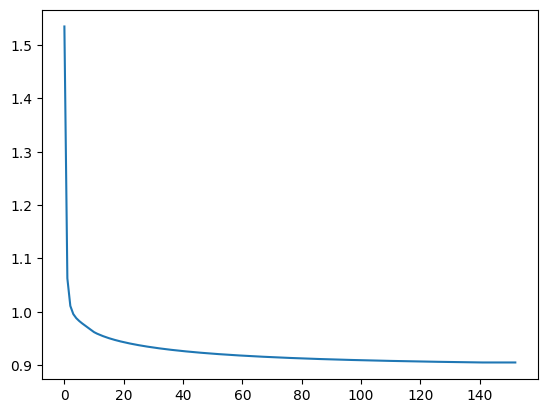

In [25]:
# plot the loss of the first sample
plt.plot(losses[0])
plt.show()


In [13]:
def plot_fft(signal, fs):
    N = len(signal)
    T = 1 / fs
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    
    plt.figure(figsize=(10, 6))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title("FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

In [27]:
small_test = x.detach().cpu().numpy().transpose(1, 2, 0, 3)[3][0].flatten()
len(small_test)

384000

3000
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])


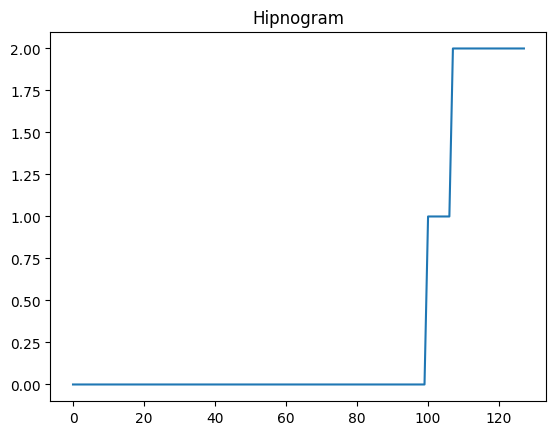

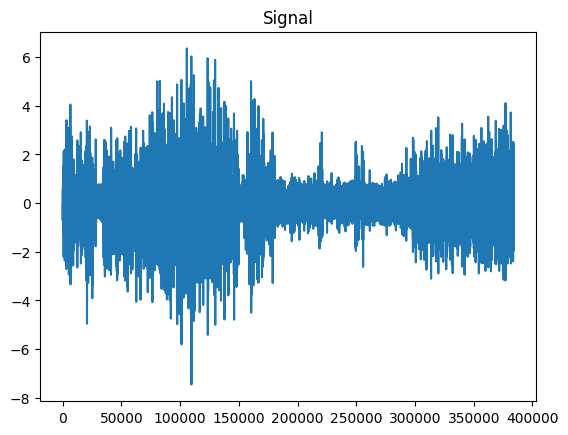

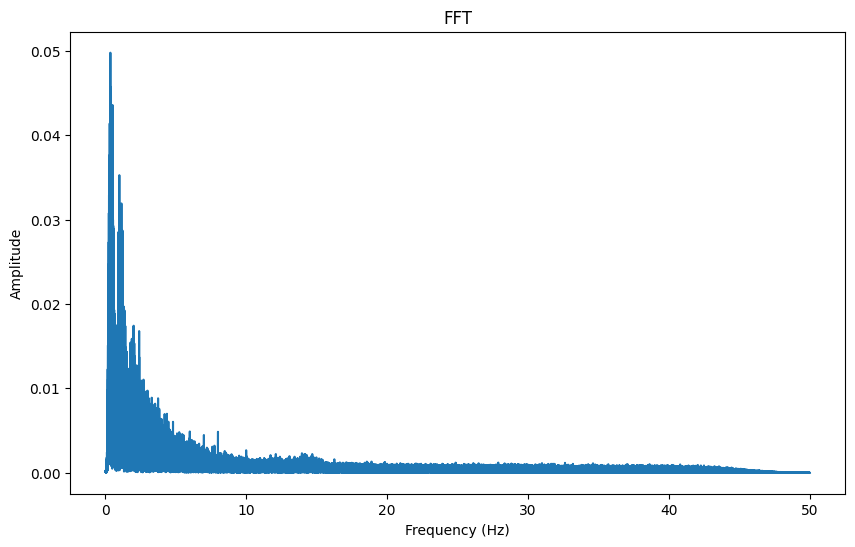

6
7


<Figure size 1000x600 with 0 Axes>

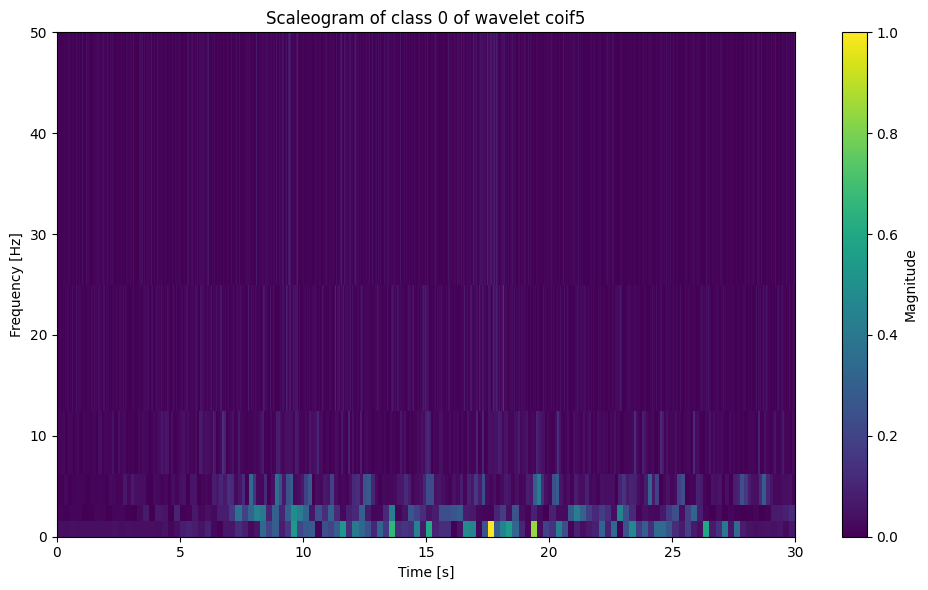

In [41]:


signal = x[0][3][0]
print(len(signal))
print(y)

# plot the hipnogram
plt.figure()
plt.plot(y)
plt.title("Hipnogram")
plt.show()

# plot the signal
plt.figure()
plt.plot(small_test)
plt.title("Signal")
plt.show()

# plot fft
plot_fft(small_test, 100)

coeffs = pywt.wavedec(signal, 'coif5', level=5)
coeffs = upsampling_wavedec(len(signal), coeffs)
print(len(coeffs))
plot_dwt_scaleogram(coeffs.T, fs=100, t=30, w='coif5', label=0)

6
7


<Figure size 1000x600 with 0 Axes>

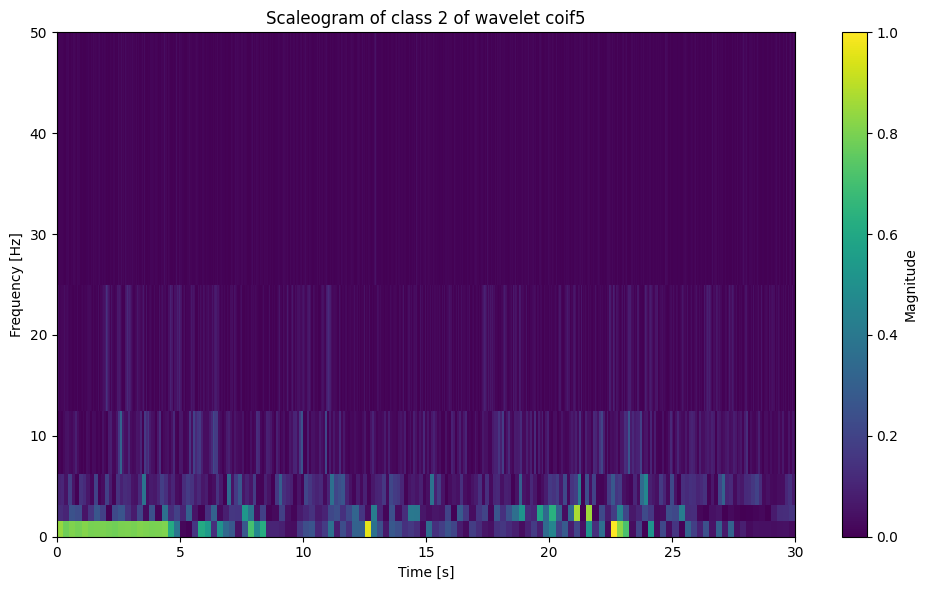

In [42]:
signal_2 = x[120][3][0]

coeffs = pywt.wavedec(signal_2, 'coif5', level=5)
coeffs = upsampling_wavedec(len(signal_2), coeffs)
print(len(coeffs))
plot_dwt_scaleogram(coeffs.T, fs=100, t=30, w='coif5', label=2)

In [16]:
def plot_scaleogram_wav_heatmap(signal, attribution, prediction:int, label:int, fs=1000 ):
    # print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(len(attribution[0]))]   # bands
    freq_bands.append(0)                                        # lowest frequency
    freq_bands = freq_bands[::-1]                               # reverse the order
    # print(freq_bands)

    time = np.linspace(0, signal / fs, signal)
    

    # normalize attribution scores to [0,1]
    attribution = np.abs(attribution)
    attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attr_norm[1:,:]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title(f'Attributions of class {label} learned through wavelet coif5')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

In [30]:
print(len(scores))
print(len(scores[0]))
print(len(scores[0][0]))
print(len(scores[0][0][0]))


52
128
7
3000


In [18]:
key_ = 'wavelet_coif5_5_128'
print(attributions.keys())
print(len(attributions[key_]))
print(attributions[key_][0].shape)

print(len(attributions[f"filtermasks_{key_}"]))
print(attributions[f"filtermasks_{key_}"][0].shape)

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_coif1_5_128', 'filtermasks_wavelet_coif1_5_128', 'complexities', 'grad_complexities', 'wavelet_coif2_5_128', 'filtermasks_wavelet_coif2_5_128', 'wavelet_coif3_5_128', 'filtermasks_wavelet_coif3_5_128', 'wavelet_coif4_5_128', 'filtermasks_wavelet_coif4_5_128', 'wavelet_coif5_5_128', 'filtermasks_wavelet_coif5_5_128'])
79
torch.Size([128, 1, 1000, 6])
79
(128, 1000, 6)


In [42]:
def plot_fft_heatmap(signal_length, attribution, label:int, fs=1000):
    N = signal_length
    freq = fftfreq(N, d=1/fs)
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    freq = np.append(freq, fs/2)

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.plot(freq, attribution)
    # plt.colorbar(label="Normalized Attribution Score")
    plt.title(f'Attributions of class {label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

    plt.show()

In [47]:
from typing import List

def plot_multi_fft_heatmap(
    attribution: List[np.ndarray], 
    label:List[int], 
    signal_length:int=3000,
    fs:int=100
):
    N = signal_length
    freq = fftfreq(N, d=1/fs)
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    freq = np.append(freq, fs/2)

    fig, axes = plt.subplots(1, len(attribution), figsize=(20, 5), sharey=True)

    # max_abs_val = max(np.max(np.abs(np.sum(attr, axis=0))) for attr in attribution)

    for i, (attr, label) in enumerate(zip(attribution, label)):
        # attr = attr / max_abs_val
        axes[i].plot(freq, attr, linestyle='-')
        axes[i].set_title(f'{label}', pad=10)
        axes[i].set_xlabel('Frequency (Hz)')
        axes[i].set_ylim(0, 1)
        axes[i].set_xlim(0, fs/2)

    plt.tight_layout()
    plt.show()

In [13]:
import torch.nn.functional as F

print(attributions['predictions'][0])

probabilities = F.softmax(attributions['predictions'][0], dim=0)
print(probabilities)

predicted = torch.argmax(attributions['predictions'][0], dim=0)
print(predicted)


predicted = []

for p in attributions['predictions']:
    # probabilities = F.softmax(p, dim=0)
    predicted.append(torch.argmax(p, dim=0))

print(len(predicted))



tensor([ 3.7968, -1.1244, -2.3120, -9.1935, -2.5675])
tensor([9.8889e-01, 7.2094e-03, 2.1984e-03, 2.2569e-06, 1.7028e-03])
tensor(0)
26322


In [37]:
print(attributions[key_][i].permute(0, 2, 1).shape)
print(attributions[key_][i].permute(0, 2, 1)[0][3].shape)
print(data_length / 2 + 1)
print(np.zeros(int(data_length / 2 + 1)).shape)

fs = 100
N = 3000
freq = fftfreq(N, d=1/fs)
pos_mask = freq >= 0
freq = freq[pos_mask]
freq = np.append(freq, 50)
print(freq.shape)
print(freq)

torch.Size([18, 7, 1501])
torch.Size([1501])
1501.0
(1501,)
(1501,)
[0.00000000e+00 3.33333333e-02 6.66666667e-02 ... 4.99333333e+01
 4.99666667e+01 5.00000000e+01]


0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3200
3264
3328
3392
3456
3520
3584
3648
3712
3776
3840
3904
3968
4032
4096
4160
4224
4288
4352
4416
4480
4544
4608
4672
4736
4800
4864
4928
4992
5056
5120
5184
5248
5312
5376
5440
5504
5568
5632
5696
5760
5824
5888
5952
6016
6080
6144
6208
6272
6336
6400
6464
6528
6592
6656
6720
6784
6848
6912
6976
7040
7104
7168
7232
7296
7360
7424
7488
7552
7616
7680
7744
7808
7872
7936
8000
8064
8128
8192
8256
8320
8384
8448
8512
8576
8640
8704
8768
8832
8896
8960
9024
9088
9152
9216
9280
9344
9408
9472
9536
9600
9664
9728
9792
9856
9920
9984
10048
10112
10176
10240
10304
10368
10432
10496
10560
10624
10688
10752
10816
10880
10944
11008
11072
11136
11200
11264
11328
11392
11456
11520
11584
11648
11712
11776
11840
11904
11968
12032
12096
12160
12224
12288
12352
12416
12480


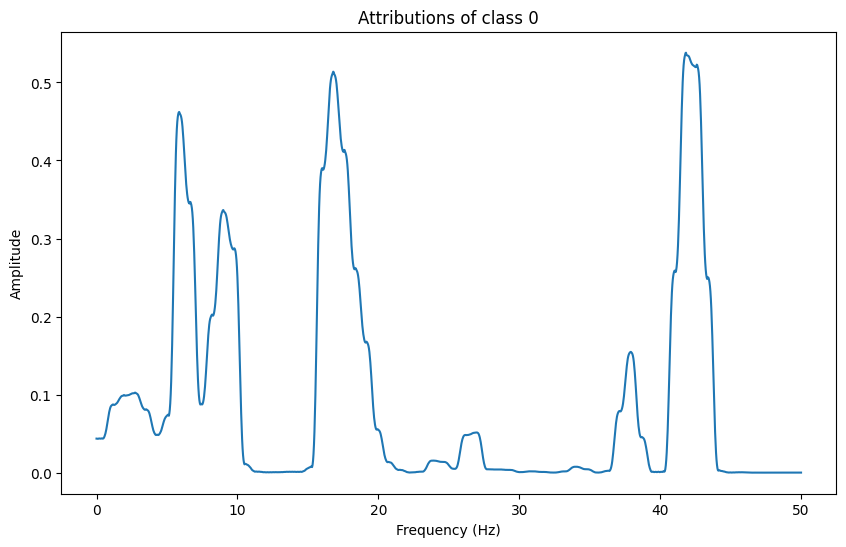

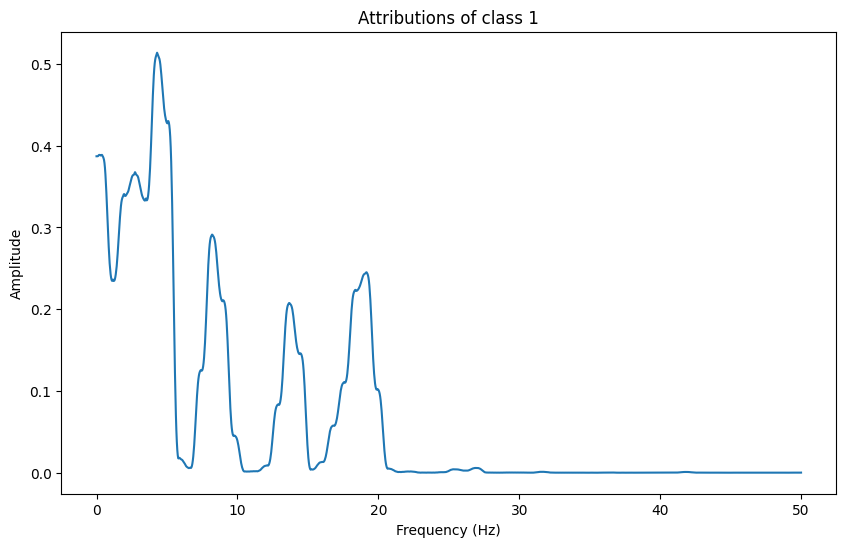

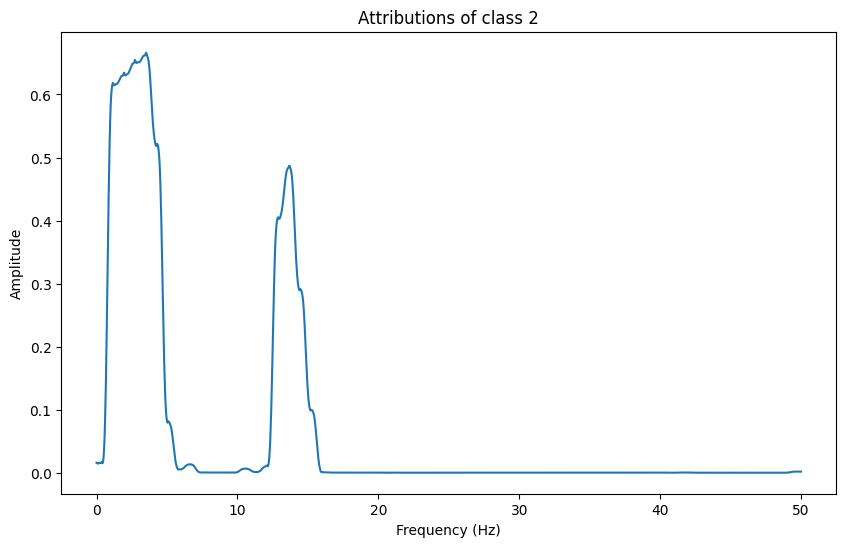

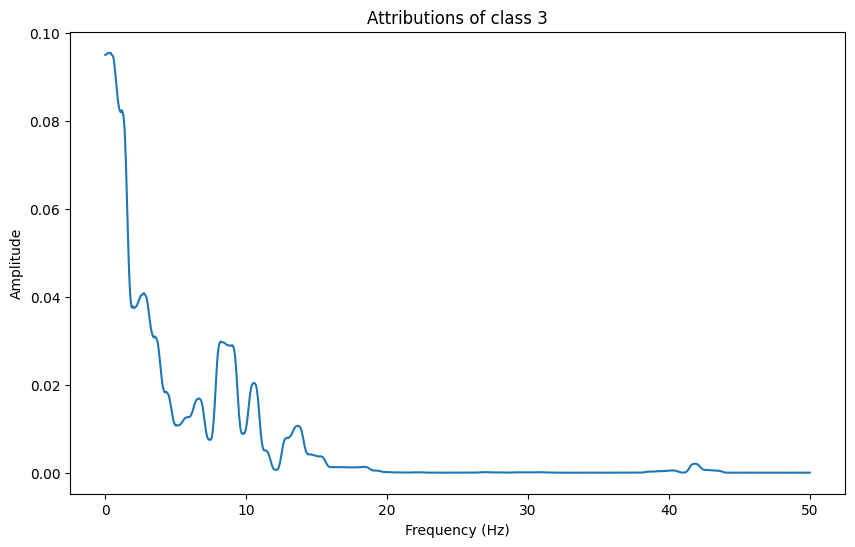

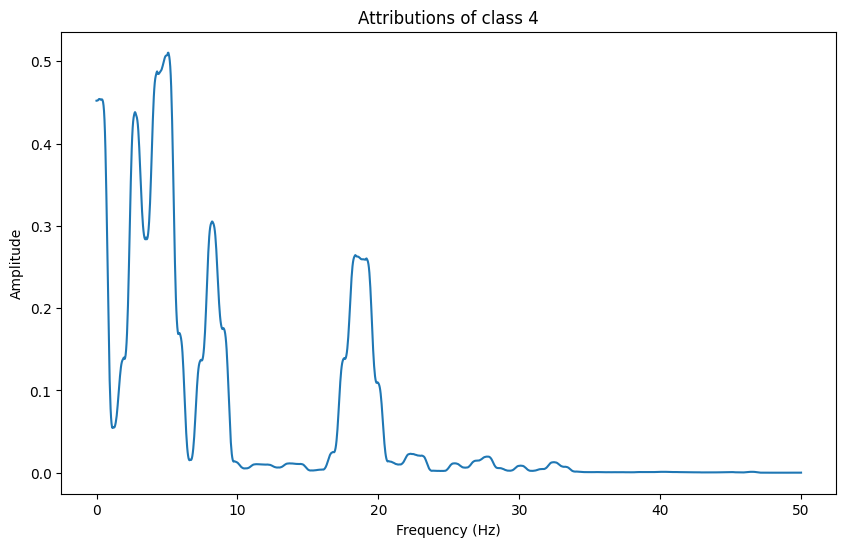

In [53]:
# "Sleep stage W": 0,
# "Sleep stage 1": 1,
# "Sleep stage 2": 2,
# "Sleep stage 3/4": 3,
# "Sleep stage REM": 4,

counts_0 = 0
counts_1 = 0
counts_2 = 0
counts_3 = 0
counts_4 = 0

data_length = 3000
fs = 100


set_seed(42)

mask_size = data_length / 2 + 1

masks_0 = np.zeros(int(mask_size))
masks_1 = np.zeros(int(mask_size))
masks_2 = np.zeros(int(mask_size))
masks_3 = np.zeros(int(mask_size))
masks_4 = np.zeros(int(mask_size))

index = 0
correct = 0

for i in range(len(test_loader)):
    scores = attributions[key_][i].permute(0, 2, 1)
    print(index)

    for j in range(len(scores)):
        if predicted[index] == attributions['labels'][index]:
            correct += 1
            results = scores[j][3].detach().cpu().numpy()
        # print(index)
            if attributions['labels'][index] == 0:
                counts_0 += 1
                masks_0 += results
            elif attributions['labels'][index] == 1:
                counts_1 += 1
                masks_1 += results
            elif attributions['labels'][index] == 2:
                counts_2 += 1
                masks_2 += results
            elif attributions['labels'][index] == 3:
                counts_3 += 1
                masks_3 += results
            elif attributions['labels'][index] == 4:
                counts_4 += 1
                masks_4 += results

        index += 1


masks_0 /= counts_0
masks_1 /= counts_1
masks_2 /= counts_2
masks_3 /= counts_3
masks_4 /= counts_4

print(f"Total samples predicted: {len(predicted)}")
print(f"Total correct {counts_0 + counts_1 + counts_2 + counts_3 + counts_4}")
print(f"Counts of label 0: {counts_0}, label 1: {counts_1}, label 2: {counts_2}, label 3: {counts_3}, label 4: {counts_4}")
print(f"Shape of mask 0: {masks_0.shape}, mask 1: {masks_1.shape}, mask 2: {masks_2.shape}, mask 3: {masks_3.shape}, mask 4: {masks_4.shape}")

plot_fft_heatmap(data_length, masks_0, label=0, fs=fs)
plot_fft_heatmap(data_length, masks_1, label=1, fs=fs)
plot_fft_heatmap(data_length, masks_2, label=2, fs=fs)
plot_fft_heatmap(data_length, masks_3, label=3, fs=fs)
plot_fft_heatmap(data_length, masks_4, label=4, fs=fs)

    

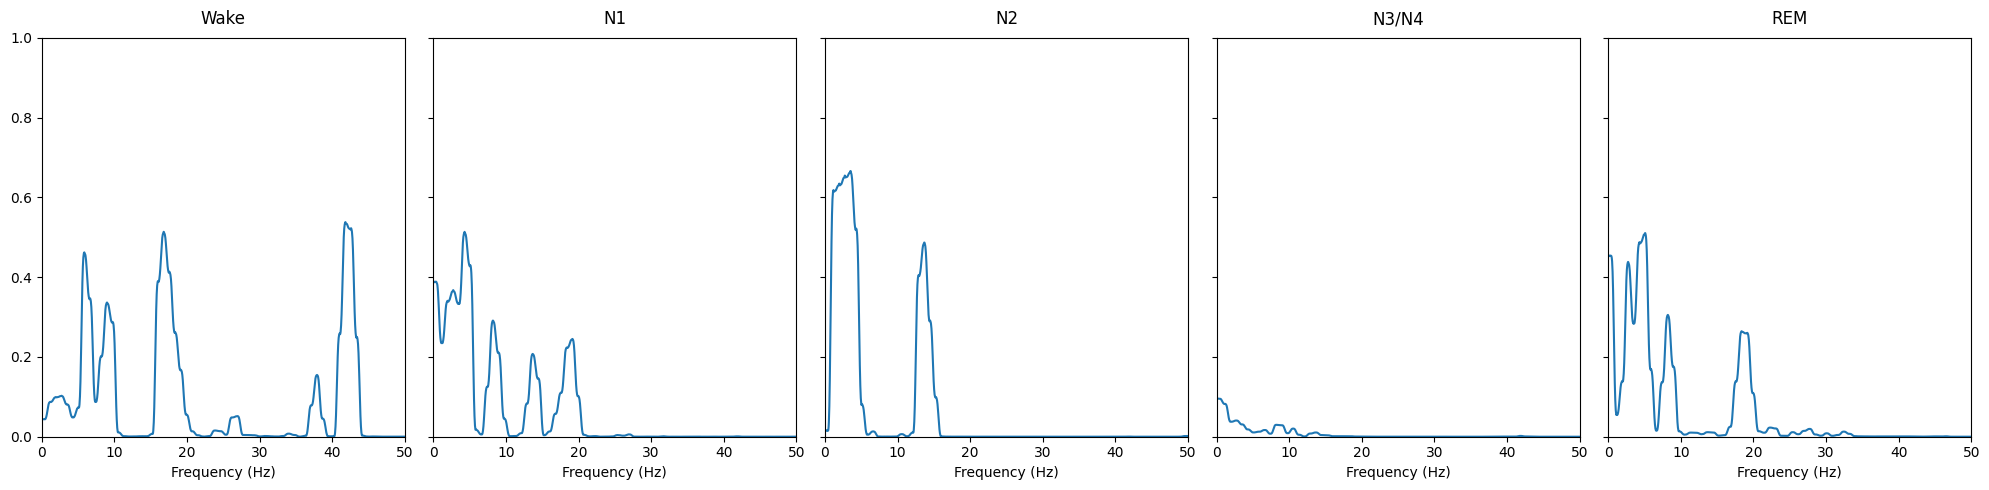

In [48]:
masks = [masks_0, masks_1, masks_2, masks_3, masks_4]
labels = ['Wake', 'N1', 'N2', 'N3/N4', 'REM']

plot_multi_fft_heatmap(masks, labels)



In [45]:
attributions[key_] = masks
attributions[f'filtermasks_{key_}'] = scores

print(len(attributions[key_]))
print(len(attributions[f'filtermasks_{key_}']))


52
52


In [46]:
# save the results in a pkl file
folder = 'public/sleepedf/'
path = f'{folder}{key_}.pkl'

with open(path, 'wb') as f:
    pickle.dump(attributions, f)
print(f"Saved to {path}")

Saved to public/sleepedf/wavelet_coif5_5_128.pkl


Counts of label 0: 5000, label 1: 5000
1
1
2
4
8


<Figure size 1000x600 with 0 Axes>

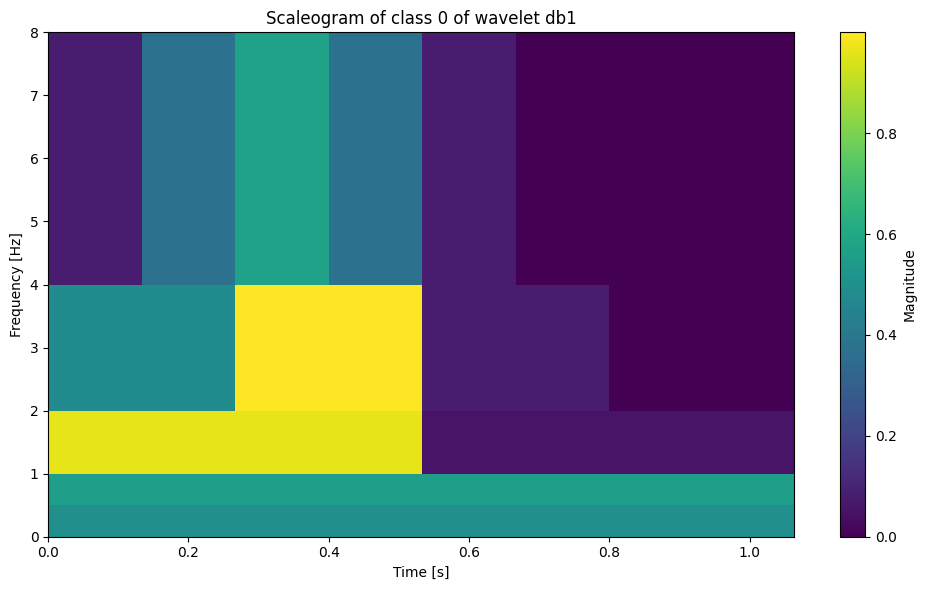

<Figure size 1000x600 with 0 Axes>

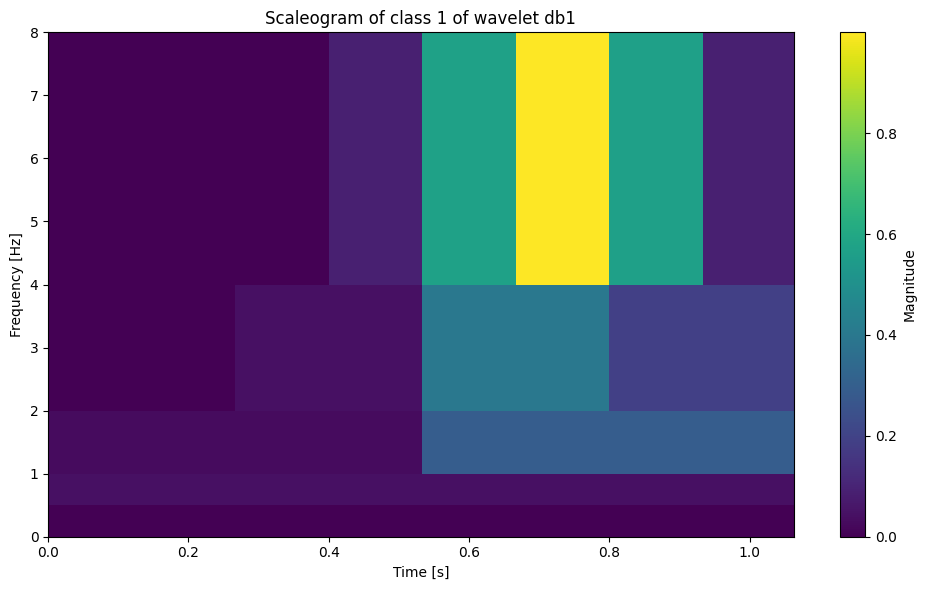

In [24]:
from src.utils.sampling import upsampling_wavedec

counts_0 = 0
counts_1 = 0

wavelets_0 = np.zeros((5, 16))
wavelets_1 = np.zeros((5, 16))

for batch in test_loader:
    x, y = batch
    
    for i, channels in enumerate(x):
        signal = channels[0].detach().cpu().numpy()

        coeffs = pywt.wavedec(signal, 'db1', level=4)
        upsampled = upsampling_wavedec(len(signal), coeffs)
        upsampled = np.abs(upsampled)

        if y[i] == 0:
            counts_0 += 1
            wavelets_0 += upsampled
        else:
            counts_1 += 1
            wavelets_1 += upsampled
    
wavelets_0 /= counts_0
wavelets_1 /= counts_1
    
print(f"Counts of label 0: {counts_0}, label 1: {counts_1}")

for c in coeffs:
    print(len(c))

upsampled = upsampling_wavedec(len(signal), coeffs)
downsampled = downsample_wavedec(len(signal), coeffs, 'db1', 1)

plot_dwt_scaleogram(wavelets_0.T, fs=fs, label=0)
plot_dwt_scaleogram(wavelets_1.T, fs=fs, label=1)